# Introduction to Data Science 2025

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="font-weight: bold">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="font-weight: bold">ratings</span>: <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, <span style="font-weight: bold">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="font-weight: bold">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [20]:
import pandas as pd
import ast
import re
from collections import Counter

df = pd.read_csv("data/ted_main.csv")

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

def rating_count(rating_list, name):
    for d in rating_list:
        if isinstance(d, dict) and d.get("name") == name:
            return int(d.get("count", 0))
    return 0

def col_safe(s):
    c = re.sub(r"\W+", "_", s).strip("_")
    return c if c else "tag"

ratings_parsed = df["ratings"].apply(safe_eval)
df["Funny"]     = ratings_parsed.apply(lambda lst: rating_count(lst, "Funny"))
df["Confusing"] = ratings_parsed.apply(lambda lst: rating_count(lst, "Confusing"))
df["Inspiring"] = ratings_parsed.apply(lambda lst: rating_count(lst, "Inspiring"))

tags_parsed = df["tags"].apply(safe_eval).apply(lambda xs: [str(x) for x in xs if pd.notna(x)])
tag_counts = Counter(tag for tags in tags_parsed for tag in tags)
top100_tags = [t for t, _ in tag_counts.most_common(100)]

seen = set()
tag_to_col = {}
for t in top100_tags:
    base = col_safe(t)
    col = base
    i = 1
    while col in seen:
        i += 1
        col = f"{base}_{i}"
    seen.add(col)
    tag_to_col[t] = col

for t, col in tag_to_col.items():
    df[col] = tags_parsed.apply(lambda lst, t=t: int(t in lst))

final_cols = ["views", "Funny", "Confusing", "Inspiring"] + list(tag_to_col.values())
final_df = df[final_cols].copy()

print(final_df.shape) 
final_df.to_csv("ted_main_features.csv", index=False)

(2550, 104)


/tmp/ipykernel_574935/3634334732.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = tags_parsed.apply(lambda lst, t=t: int(t in lst))
/tmp/ipykernel_574935/3634334732.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = tags_parsed.apply(lambda lst, t=t: int(t in lst))
/tmp/ipykernel_574935/3634334732.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

2. Construct a linear regression model to predict the number of views based on the data in the <span style="font-weight: bold">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [21]:


features = pd.read_csv("ted_main_features.csv")  

# Split 
y = features["views"].astype(float)
X = features.drop(columns=["views"])

# Train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# OLS
lin = LinearRegression()
lin.fit(X_train, y_train)

# Eval
y_pred = lin.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:,.0f}")
print(f"Test R^2 : {r2:0.3f}")




Test RMSE: 1,123,480
Test R^2 : 0.675


3. Do the same for the <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, and <span style="font-weight: bold">Inspiring</span> ratings.

In [22]:

features = pd.read_csv("ted_main_features.csv")  # columns: views, Funny, Confusing, Inspiring, <100 tag columns>

rating_targets = ["Funny", "Confusing", "Inspiring"]

def run_linear_for_target(df, target, test_size=0.20, seed=42, show_coef=10):
    # Features: everything except 'views' and the target rating
    drop_cols = {"views", target}
    X = df.drop(columns=list(drop_cols))
    y = df[target].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print(f"\n=== Linear Regression (predict {target}) ===")
    print(f"Test RMSE: {rmse:,.2f}")
    print(f"Test R^2 : {r2:0.3f}")

    # Coefficients
    coef = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
    print("\nTop + coefficients:")
    print(coef.head(show_coef).round(3))
    print("\nTop - coefficients:")
    print(coef.tail(show_coef).round(3))

    return model, X.columns, coef

models = {}
for tgt in rating_targets:
    models[tgt] = run_linear_for_target(features, tgt)



=== Linear Regression (predict Funny) ===
Test RMSE: 301.38
Test R^2 : 0.324

Top + coefficients:
humor             868.461
mind              294.662
children          188.449
writing           156.265
entertainment     138.387
work              121.549
creativity        114.284
visualizations    104.662
economics          82.302
Internet           78.370
dtype: float64

Top - coefficients:
family             -67.356
personal_growth    -80.653
business           -82.946
identity           -86.970
illness            -89.330
philosophy        -106.796
computers         -114.123
neuroscience      -139.580
live_music        -142.524
poetry            -213.816
dtype: float64

=== Linear Regression (predict Confusing) ===
Test RMSE: 26.50
Test R^2 : 0.224

Top + coefficients:
physics          18.430
evolution        18.140
religion         14.825
philosophy       13.742
brain            11.250
math              9.442
science           7.242
performance       7.199
culture           6.549
en

4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

features = pd.read_csv("ted_main_features.csv")

resp = ["views", "Funny", "Confusing", "Inspiring"]
tag_cols = [c for c in features.columns if c not in resp]

def lasso_select_tags(X_tags: pd.DataFrame, y, log_transform=False, cv=5, top_n=25):
    y_fit = np.log1p(y) if log_transform else y
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", LassoCV(cv=cv, random_state=42, n_alphas=200, max_iter=10000))
    ])
    pipe.fit(X_tags.values, y_fit.values.astype(float))
    lasso = pipe.named_steps["lasso"]
    coef = pd.Series(lasso.coef_, index=X_tags.columns)
    nonzero = coef[coef.abs() > 1e-8].sort_values(key=np.abs, ascending=False)
    top = nonzero.head(top_n).rename("coef").reset_index().rename(columns={"index":"tag"})
    return top, float(lasso.alpha_), nonzero

X_tags = features[tag_cols]

views_top_log, alpha_views_log, views_all_log = lasso_select_tags(X_tags, features["views"], log_transform=True)
views_top_raw, alpha_views_raw, views_all_raw = lasso_select_tags(X_tags, features["views"], log_transform=False)

print(" Best tag predictors for views (log1p model) ")
print(f"Chosen alpha: {alpha_views_log:.6f}")
print(views_top_log.to_string(index=False))

print("\n Best tag predictors for views (raw model) ")
print(f"Chosen alpha: {alpha_views_raw:.6f}")
print(views_top_raw.to_string(index=False))

# Funny
funny_top, alpha_funny, funny_all = lasso_select_tags(X_tags, features["Funny"], log_transform=False)
print("\n Best tag predictors for Funny ")
print(f"Chosen alpha: {alpha_funny:.6f}")
print(funny_top.to_string(index=False))

# Confusing
conf_top, alpha_conf, conf_all = lasso_select_tags(X_tags, features["Confusing"], log_transform=False)
print("\ Best tag predictors for Confusing ")
print(f"Chosen alpha: {alpha_conf:.6f}")
print(conf_top.to_string(index=False))

# Inspiring
insp_top, alpha_insp, insp_all = lasso_select_tags(X_tags, features["Inspiring"], log_transform=False)
print("\n Best tag predictors for Inspiring ")
print(f"Chosen alpha: {alpha_insp:.6f}")
print(insp_top.to_string(index=False))



<>:47: SyntaxWarning: invalid escape sequence '\ '
<>:47: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_574935/1908536385.py:47: SyntaxWarning: invalid escape sequence '\ '
  print("\ Best tag predictors for Confusing ")
/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' wi

 Best tag predictors for views (log1p model) 
Chosen alpha: 0.019846
          tag      coef
   psychology  0.076664
         work  0.066119
global_issues -0.063268
         TEDx -0.058820
      culture  0.053120
       Africa -0.049427
   motivation  0.044737
       design -0.043421
    education  0.039221
        brain  0.037038
     politics -0.036990
         demo  0.035056
          art -0.035005
    happiness  0.034299
mental_health  0.033885
       oceans -0.033629
      poverty -0.023739
       cities -0.023268
  health_care -0.023136
          war -0.020431
   technology -0.019996
        music -0.019768
   live_music -0.019061
        humor  0.018359
communication  0.018179

 Best tag predictors for views (raw model) 
Chosen alpha: 49087.112179
          tag           coef
   psychology  337529.539163
      culture  203260.101780
         work  156886.430266
        brain  123847.246974
   motivation  120623.538510
global_issues -116371.016643
         demo  103932.134887
men

/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


\ Best tag predictors for Confusing 
Chosen alpha: 0.317713
             tag      coef
         culture  3.349092
       evolution  2.741182
           brain  2.612126
      philosophy  2.491698
      psychology  2.444067
         physics  2.252216
        religion  2.018580
         science  1.943544
   entertainment  1.799168
      innovation -1.684974
            math  1.406328
          Africa -1.311241
         animals -1.270440
           music -1.193836
            TEDx -1.163909
          oceans -1.022193
         history -1.014677
          nature -0.982700
           humor  0.977502
       happiness  0.963597
        business  0.947084
medical_research -0.855874
          health -0.851240
            life -0.775982
           women -0.763322


/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



 Best tag predictors for Inspiring 
Chosen alpha: 33.696952
             tag       coef
      psychology 150.911323
   mental_health  95.579090
            work  89.696388
       education  85.154973
         culture  76.584306
        business  64.413731
       happiness  62.669924
      creativity  57.046969
      motivation  53.548044
       economics -52.747680
    neuroscience -43.476564
         science -39.055585
      technology -32.694545
             art -31.914602
         history -23.736329
            life  19.798789
          design -15.562053
    entrepreneur  14.409767
         writing  11.622410
         society  -8.324407
        genetics  -7.365956
medical_research  -6.900148
     TED_Fellows  -6.440636
             war  -4.397575
   collaboration  -3.640146


5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

In [35]:


features = pd.read_csv("ted_main_features.csv")
targets = {
    "views (log1p)": ("views", True), 
    "Funny": ("Funny", False),
    "Confusing": ("Confusing", False),
    "Inspiring": ("Inspiring", False),
}
resp_cols = ["views", "Funny", "Confusing", "Inspiring"]
tag_cols = [c for c in features.columns if c not in resp_cols]
X = features[tag_cols]

def lasso_select(X_tags: pd.DataFrame, y: pd.Series, log=False, topn=10):
    y_fit = np.log1p(y) if log else y
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", LassoCV(cv=5, random_state=42, n_alphas=200, max_iter=20000))
    ])
    pipe.fit(X_tags.values, y_fit.values.astype(float))
    coefs = pd.Series(pipe.named_steps["lasso"].coef_, index=X_tags.columns)
    nonzero = coefs[coefs.abs() > 1e-8].sort_values(key=np.abs, ascending=False)
    pos = nonzero[nonzero > 0].head(topn)
    neg = nonzero[nonzero < 0].tail(topn)  
    alpha = float(pipe.named_steps["lasso"].alpha_)
    return pos, neg, alpha, nonzero

summary_rows = []
recommend_text = []

for label, (col, do_log) in targets.items():
    pos, neg, alpha, allnz = lasso_select(X, features[col], log=do_log, topn=10)

    print(f"\n=== {label} — LASSO-selected tags (alpha={alpha:.6f}) ===")
    print("\nTop positive tags (associated with higher target):")
    print(pos.round(4).to_string())
    print("\nTop negative tags (associated with lower target):")
    print(neg.round(4).to_string())

    for tag, coef in pos.items():
        summary_rows.append({"target": label, "tag": tag, "coef": float(coef), "direction": "positive"})
    for tag, coef in neg.items():
        summary_rows.append({"target": label, "tag": tag, "coef": float(coef), "direction": "negative"})

    def nice_list(s):
        return ", ".join(s.index.tolist())

    rec_good = nice_list(pos)
    rec_avoid = nice_list(neg.sort_values())  

    if label == "views (log1p)":
        recommend_text.append(
            f"- For **more views**: {rec_good or '[none selected]'}; "
            f"Do not use{rec_avoid or '[none selected]'}."
        )
    elif label == "Funny":
        recommend_text.append(
            f"- To boost **Funny** ratings: {rec_good or '[none selected]'}; "
            f"Do not use{rec_avoid or '[none selected]'}."
        )
    elif label == "Confusing":
        recommend_text.append(
            f"- To **reduce Confusing** ratings avoid {rec_good or '[none selected]'} "
            f"Tags linked with *lower* {rec_avoid or '[none selected]'}."
        )
    elif label == "Inspiring":
        recommend_text.append(
            f"- To raise **Inspiring** ratings:  {rec_good or '[none selected]'}; "
            f"de-emphasize {rec_avoid or '[none selected]'}."
        )

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("lasso_top_tags_summary.csv", index=False)



/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



=== views (log1p) — LASSO-selected tags (alpha=0.019846) ===

Top positive tags (associated with higher target):
psychology       0.0767
work             0.0661
culture          0.0531
motivation       0.0447
education        0.0392
brain            0.0370
demo             0.0351
happiness        0.0343
mental_health    0.0339
humor            0.0184

Top negative tags (associated with lower target):
science         -0.0174
history         -0.0124
ecology         -0.0121
poetry          -0.0074
disease         -0.0069
media           -0.0047
social_change   -0.0031
green           -0.0022
genetics        -0.0016
activism        -0.0010


/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



=== Funny — LASSO-selected tags (alpha=20.858358) ===

Top positive tags (associated with higher target):
humor            146.5007
culture           34.6371
entertainment     33.4862
psychology        24.7170
work              24.3986
creativity        20.8319
education         16.4943
children          12.6588
happiness          9.7226
motivation         7.8696

Top negative tags (associated with lower target):
global_issues   -10.3229
design           -5.7843
art              -3.6354


/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



=== Confusing — LASSO-selected tags (alpha=0.317713) ===

Top positive tags (associated with higher target):
culture          3.3491
evolution        2.7412
brain            2.6121
philosophy       2.4917
psychology       2.4441
physics          2.2522
religion         2.0186
science          1.9435
entertainment    1.7992
math             1.4063

Top negative tags (associated with lower target):
children            -0.1945
data                -0.1898
sustainability      -0.1169
poverty             -0.1066
war                 -0.1065
art                 -0.0853
invention           -0.0553
cognitive_science   -0.0541
climate_change      -0.0296
mental_health       -0.0089


/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(



=== Inspiring — LASSO-selected tags (alpha=33.696952) ===

Top positive tags (associated with higher target):
psychology       150.9113
mental_health     95.5791
work              89.6964
education         85.1550
culture           76.5843
business          64.4137
happiness         62.6699
creativity        57.0470
motivation        53.5480
life              19.7988

Top negative tags (associated with lower target):
design             -15.5621
society             -8.3244
genetics            -7.3660
medical_research    -6.9001
TED_Fellows         -6.4406
war                 -4.3976
collaboration       -3.6401
humor               -1.8206
music               -0.6619
disease             -0.1972


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make its prediction. Without tuning any parameters, how is the accuracy?

In [ ]:
# Use this cell for your code
import pandas as pd
import numpy as np
from PIL import Image

df = pd.read_csv('hasy-data-labels.csv')
df = df[df.symbol_id >= 70]
df = df[df.symbol_id <= 79]
img_data = []
targets = []

for index, row in df.iterrows():
    img = Image.open(row['path'])
    img = img.convert("L")
    img = np.array(img.getdata())
    img_data.append(img)
    targets.append(row['latex'])

img_data = np.array(img_data)

print('image data shape = ', img_data.shape)
print('target vector length = ', len(targets))


from sklearn.model_selection import train_test_split

training_data, test_data, train_target, test_target = train_test_split(img_data, targets, train_size=0.8)
print('sample size = ', len(img_data))
print('training_data size = ', len(training_data))
print('test_data size = ', len(test_data))

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators= 300, random_state=42, n_jobs=-1)
rf = model.fit(training_data, train_target)

preds = model.predict(test_data)
print('test accuracy = ', accuracy_score(test_target, preds))

image data shape =  (1020, 1024)
target vector length =  1020
sample size =  1020
training_data size =  816
test_data size =  204
test accuracy =  0.8284313725490197


2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

10 trees -> test accuracy: 0.7304
20 trees -> test accuracy: 0.7598
30 trees -> test accuracy: 0.7794
40 trees -> test accuracy: 0.7941
50 trees -> test accuracy: 0.7941
60 trees -> test accuracy: 0.8235
70 trees -> test accuracy: 0.8039
80 trees -> test accuracy: 0.8235
90 trees -> test accuracy: 0.8431
100 trees -> test accuracy: 0.8333
110 trees -> test accuracy: 0.8382
120 trees -> test accuracy: 0.8431
130 trees -> test accuracy: 0.8333
140 trees -> test accuracy: 0.8186
150 trees -> test accuracy: 0.8235
160 trees -> test accuracy: 0.8333
170 trees -> test accuracy: 0.8137
180 trees -> test accuracy: 0.8235
190 trees -> test accuracy: 0.8235
200 trees -> test accuracy: 0.8235


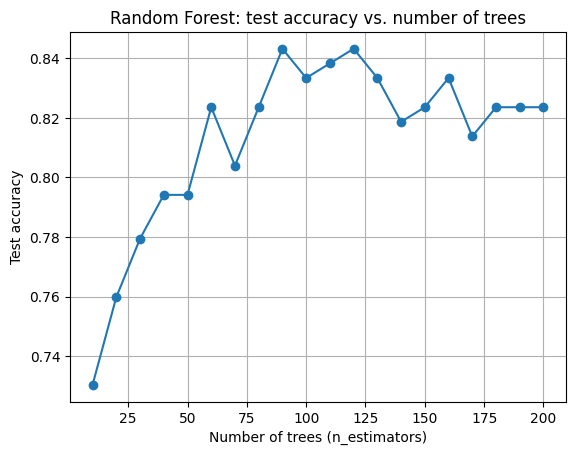

In [ ]:
# Use this cell for your code
import matplotlib.pyplot as plt
n_trees_list = np.arange(10, 201, 10)
accuracies = []

for n in n_trees_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(training_data, train_target)
    preds = rf.predict(test_data)
    acc = accuracy_score(test_target, preds)
    accuracies.append(acc)
    print(f"{n} trees -> test accuracy: {acc:.4f}")

plt.figure()
plt.plot(n_trees_list, accuracies, marker='o')
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Test accuracy")
plt.title("Random Forest: test accuracy vs. number of trees")
plt.grid(True)
plt.show()

3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

*You can use this markdown cell to write down your thoughts.*

Because the test set must simulate the unseen data, so if we try hyperparameters and choose the one with the highest test accuracy we've used the test set to make training choices which leak information.

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [ ]:
# Use this cell for your code
X_train, X_temp, y_train, y_temp = train_test_split(
    img_data, targets, test_size=0.20, stratify=targets, random_state=123, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=123, shuffle=True
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [1, 2],
}

best_acc = -1.0
best_params = None
results = []

for n in param_grid["n_estimators"]:
    for md in param_grid["max_depth"]:
        for mf in param_grid["max_features"]:
            for msl in param_grid["min_samples_leaf"]:
                clf = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=md,
                    max_features=mf,
                    min_samples_leaf=msl,
                    n_jobs=-1,
                    random_state=123,
                )
                clf.fit(X_train, y_train)
                val_acc = accuracy_score(y_val, clf.predict(X_val))
                train_acc = accuracy_score(y_train, clf.predict(X_train))
                results.append((n, md, mf, msl, train_acc, val_acc))
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_params = (n, md, mf, msl)

print("Best valid accuracy: {:.4f} with params: n_estimators={}, max_depth={}, max_features={}, min_samples_leaf={}"
      .format(best_acc, *best_params))

X_trval = np.vstack([X_train, X_val])
y_trval = np.hstack([y_train, y_val])

best_clf = RandomForestClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    max_features=best_params[2],
    min_samples_leaf=best_params[3],
    n_jobs=-1,
    random_state=123,
)
best_clf.fit(X_trval, y_trval)

trval_acc = accuracy_score(y_trval, best_clf.predict(X_trval))
test_acc  = accuracy_score(y_test,  best_clf.predict(X_test))

print(f"Train+Val accuracy {trval_acc:.4f}")
print(f"Final TEST accuracy {test_acc:.4f}")

Train: 816, Val: 102, Test: 102
Best validation accuracy: 0.8824 with params: n_estimators=200, max_depth=None, max_features=sqrt, min_samples_leaf=1
Train+Val accuracy (fit on Train+Val): 1.0000
Final TEST accuracy (never used in tuning): 0.9020


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 3 | TPOT

The process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [33]:
# Use this cell for your code
import pandas as pd
import numpy as np
from PIL import Image

# read the labels/image paths and select the symbol IDs within the inclusive range [70, 79]
df = pd.read_csv('hasy-data-labels.csv')
df = df[(df.symbol_id >= 70) & (df.symbol_id <= 79)]

img_data, targets = [], []
for _, row in df.iterrows():
    img = Image.open(row['path']).convert("L")
    img = np.array(img.getdata())
    img_data.append(img)
    targets.append(row['latex'])

X = np.array(img_data)
y = np.array(targets)

print('image data shape = ', X.shape)
print('target vector length = ', len(y))

from tpot import TPOTClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

tpot = TPOTClassifier(
search_space="linear-light", max_time_mins=30/60, n_jobs=1, cv=5
)

tpot.fit(X, y)

best_pipeline = clone(tpot.fitted_pipeline_)
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, n_jobs=1)
print(f"Best pipeline 5-fold CV accuracy: mean={best_pipeline}, std={cv_scores.std():.4f}")



image data shape =  (1020, 1024)
target vector length =  1020


/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43321 instead
  warnings.warn(
/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/tpot/tpot_estimator/estimator.py:537: UserWarning: Labels are not encoded as ints from 0 to N. For compatibility with some classifiers such as sklearn, TPOT has encoded y with the sklearn LabelEncoder. When using pipelines outside the main TPOT estimator class, you can encode the labels with est.label_encoder_
  warnings.warn("Labels are not encoded as ints from 0 to N. For compatibility with some classifiers such as sklearn, TPOT has encoded y with the sklearn LabelEncoder. When using pipelines outside the main TPOT estimator class, you can encode the labels with est.label_encoder_")
Generation: : 0it [00:00, ?it/s]/home/haarhaar/.pyenv/versions/3.13.1/lib/python3.13/site-packages/s

Best pipeline 5-fold CV accuracy: mean=Pipeline(steps=[('normalizer', Normalizer(norm=np.str_('l2'))),
                ('selectfwe', SelectFwe(alpha=0.0064943025237)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('quantiletransformer',
                                                                                 QuantileTransformer(n_quantiles=329,
                                                                                                     output_distribution=np.str_('uniform')))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthroug

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**